# Data exploration

## Imports

In [1]:
import os
os.environ["PROJ_LIB"] = os.path.join(os.environ["CONDA_PREFIX"], "share", "proj")

In [2]:
from os import listdir
from os.path import isfile, join
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LinearSegmentedColormap
import re
from IPython import display
import glob
import imageio
from datetime import datetime
from tqdm import tqdm
import re
import netCDF4
from pyproj import Proj, transform
import mpl_toolkits

In [3]:
from data_functions import *

## Data loader

In [4]:
dir_rtcor = '/Volumes/lacie_msc_datascience/msc_thesis/ceph_knmimo/dataset_radar/'
rtcor_fbase = 'RAD_NL25_RAC_RT_'
dir_aart = '/Volumes/lacie_msc_datascience/msc_thesis/ceph_knmimo/dataset_aart/'
aart_fbase = 'RAD_NL25_RAC_MFBS_EM_5min_'

#RAD_NL25_RAC_5M_

In [5]:
radar_dir = dir_rtcor
files = sorted([f for f in listdir(radar_dir) if isfile(join(radar_dir, f))])
print(len(files))

104034


In [24]:
#rtcor_dir = '/Volumes/lacie_msc_datascience/msc_thesis/ceph_knmimo/dataset_rtcor/'
#files_rtcor = sorted([f for f in listdir(rtcor_dir) if isfile(join(rtcor_dir, f))])
#print(len(files_rtcor))

In [26]:
#files_aart = sorted([f for f in listdir(dir_aart) if isfile(join(dir_aart, f))])
#print(len(files_aart))

In [17]:
regex_timestamp = re.compile('(\d{12})\.h5')
def get_datetime(filename):
    '''
    Infer datetime from filename
    '''
    timestamp=None
    dt=None
    # check if regex pattern finds a timestamp
    try:
        timestamp = regex_timestamp.findall(filename)[0]
        dt = datetime.strptime(str(timestamp), '%Y%m%d%H%M')
    except:
        print('Error: could not find timestamp in file {}'.format(filename))
    return dt

def get_diff_minutes(d1, d2):
    '''
    Returns the difference in minutes between first date d1 and the next date d2
    '''
    diff = int((d2-d1).seconds / 60)
    return diff

def gap_between(filename1, filename2, gapsize=5):
    '''
    Checks if difference in time between two consecutive files is 5 minutes.
    If it is not, print the two timestamps
    Returns the number of scans missing between two files (time difference/5)
    '''
    #print(filename1, filename2)
    d1 = get_datetime(filename1)
    d2 = get_datetime(filename2)

    diff = get_diff_minutes(d1, d2)

    if diff != 5 and diff != gapsize:
        print('{} minutes gap between {} and {}'.format(diff,d1,d2))
        return diff/5
    return 0

In [18]:
radar_scans = files
gaps=[]
for i in range(0,len(radar_scans)-2):
    # check if tim
    gap_size = gap_between(radar_scans[i+1],radar_scans[i+2], gapsize=10)
    if  gap_size != 0:
        gaps.append([radar_scans[i], radar_scans[i+1], gap_size])
gaps=np.array(gaps)
print('There are {} gaps in the data'.format(len(gaps)))
nr_missing_scans=int(sum(map(float, gaps[:,2])))
total_scans = (len(radar_scans) + nr_missing_scans)
perc_missing = nr_missing_scans/total_scans
print('Missing {} out of the {} radar scans ({:.2f}%)'.format(nr_missing_scans, total_scans, perc_missing))
print('From {} till {}'.format(get_datetime(radar_scans[0]), get_datetime(radar_scans[-1])))

245 minutes gap between 2018-12-20 19:55:00 and 2019-01-01 00:00:00
15 minutes gap between 2019-01-12 12:30:00 and 2019-01-12 12:45:00
15 minutes gap between 2019-01-12 14:10:00 and 2019-01-12 14:25:00
15 minutes gap between 2019-01-12 14:35:00 and 2019-01-12 14:50:00
15 minutes gap between 2019-01-12 20:35:00 and 2019-01-12 20:50:00
130 minutes gap between 2019-02-08 23:05:00 and 2019-02-09 01:15:00
65 minutes gap between 2019-02-09 01:30:00 and 2019-02-09 02:35:00
15 minutes gap between 2019-02-14 10:45:00 and 2019-02-14 11:00:00
50 minutes gap between 2019-03-31 18:55:00 and 2019-03-31 19:45:00
15 minutes gap between 2019-04-08 21:05:00 and 2019-04-08 21:20:00
75 minutes gap between 2019-04-30 18:05:00 and 2019-04-30 19:20:00
390 minutes gap between 2019-05-27 22:55:00 and 2019-05-28 05:25:00
75 minutes gap between 2019-07-09 08:30:00 and 2019-07-09 09:45:00
30 minutes gap between 2019-07-27 17:30:00 and 2019-07-27 18:00:00
30 minutes gap between 2019-09-17 08:50:00 and 2019-09-17 0

108615 instead of 228474

RAD_NL25_RAC_RT_201812201945.h5


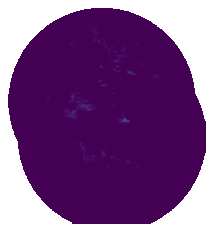

In [78]:
print(files[10])
file_name_rdr = files[10]
rdr = load_radar(filename=file_name_rdr, dir_rtcor=dir_rtcor, rtcor_fbase=rtcor_fbase, dir_aart=dir_aart, aart_fbase=aart_fbase)
plot_radar(rdr)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  50  53  54  58  60
  62  76 107 162]


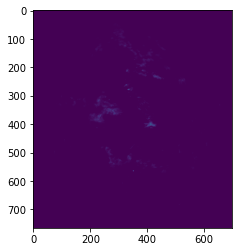

[32768 65535]


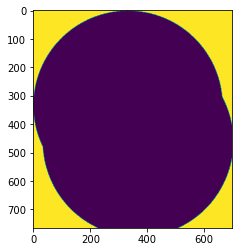

In [79]:
h5f = h5py.File(dir_rtcor+files[10], 'r')
radar_img = np.array(h5f['image1']['image_data'])
# change masked values to 0
radar_img[radar_img == 65535] = 0
plt.imshow(radar_img)
print(np.unique(radar_img.flatten()))
plt.show()

img_mask = np.array(h5f['image2']['image_data'])
print(np.unique(img_mask.flatten()))
plt.imshow(img_mask) # interpolation='none'
plt.show()

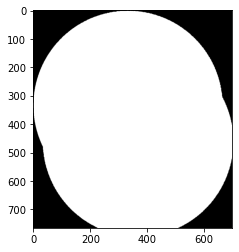

In [80]:
mask = get_mask(h5f)
plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
plt.show()

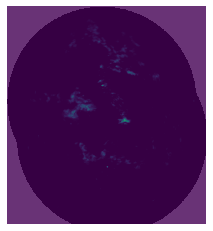

In [83]:
h5f = h5py.File(dir_rtcor+files[10], 'r')
plot_radar(h5f,show_mask=True)

## Data exploration of radar images for precipitation

### Number of days 2020

In [84]:
base = 'RAD_NL25_RAC_RT_'
# Get start and end index
# 2020 01 01 00:00
start = base + '202001201900.h5'
# 2020 12 31 11:55
end = base + '202012201955.h5'
start_i = files.index(start)
end_i = files.index(end)
print(start_i, end_i)
files_2020 = files[start_i:end_i]
print(len(files_2020))
print('Nr. of days in dataset 2020: ', len(files_2020)/288)

103866 104009
143
Nr. of days in dataset 2020:  0.4965277777777778


0.497 instead of 365

### Number of days 2019

In [85]:
base = 'RAD_NL25_RAC_RT_'
# Get start and end index
start = base + '201901010000.h5'
end = base + '201912312355.h5'
start_i = files.index(start)
end_i = files.index(end)
print(start_i, end_i)
files_2019 = files[start_i:end_i]
print(len(files_2019))
print('Nr. of days in dataset 2019: ', len(files_2019)/288)

13 103865
103852
Nr. of days in dataset 2019:  360.59722222222223


### Rain in 2019

In [ ]:
sum_rain2019 = []
empty_files=[]
for file in tqdm(files_2019):
    date = get_datetime(file)
    rdr = load_radar(filename=file, dir_rtcor=dir_rtcor, rtcor_fbase=rtcor_fbase, dir_aart=dir_aart, aart_fbase=aart_fbase, as_int=True)
    try:
        sum_rain2019.append([date, int(rdr.sum())])
    except:
        print(date)
        sum_rain2019.append([date, 0])
np_arr = np.array(sum_rain2019)

In [ ]:
np.save('/Volumes/lacie_msc_datascience/msc_thesis/github_pycharm/sum_rain2019', np_arr)

In [ ]:
df = pd.DataFrame({'date': np_arr[:, 0], 'mean_rain': np_arr[:, 1]})
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.head()

In [ ]:
monthly_rain = df.mean_rain.resample('M').sum()
monthly_rain.plot()

### .npy data

In [89]:
radar_dir_np = '/Volumes/lacie_msc_datascience/msc_thesis/ceph_knmimo/preprocessed/rtcor/'
files = sorted([f for f in listdir(radar_dir_np) if isfile(join(radar_dir_np, f)) and f.startswith('2019')])
print(len(files))

6120


In [90]:
print(files[0], files[-1])

201901130430.npy 201912292030.npy


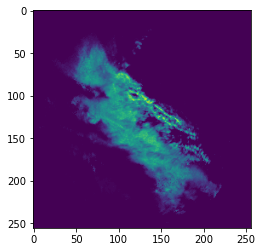

In [94]:
f = '201906060025.npy'
rdr = np.load(radar_dir_np+f)
rdr[rdr == 65535] = 0
#rdr[rdr > 500] = 0
plt.imshow(rdr)

201906060000.npy
[0.7213282  0.7304109  0.7394824  0.76675385 0.7758008 ]
0.05173
No pixel above 0.3mm: True
Number of rainy pixels: [0]
0


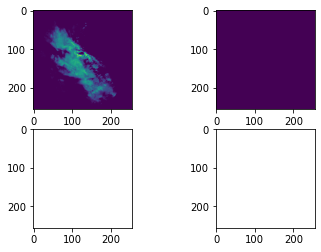

In [102]:
thresh_up=100*100
thresh_low=100*0.3

f ='201906060000.npy'
rdr = np.load(radar_dir_np+f)
rdr[rdr == 255] = 0
rdr[rdr == 65535] = 0
print(f)
print(np.unique(rdr)[-5:])
print('{:.5f}'.format(rdr.mean()))

rdr2 = np.load(radar_dir_np+f)

print('No pixel above 0.3mm:', rdr.max()<thresh_low)
print('Number of rainy pixels:', sum(sum(rdr>thresh_low)))
rdr2[rdr2 == 65535] = 0
rdr2[np.logical_or(rdr2 > thresh_up, rdr2 < thresh_low )] = 0

rdr3 = np.load(radar_dir_np+f)
print(np.sum(rdr3==65535))
rdr3[rdr3 == 65535] = 0
rdr3 = rdr3 > thresh_up

rdr4 = np.load(radar_dir_np+f)
rdr4[rdr4 == 65535] = 0
rdr4 = rdr4 < thresh_low

plt.figure()
plt.subplot(2,2,1)
plt.imshow(rdr)
plt.subplot(2,2,2)
plt.imshow(rdr2)
plt.subplot(2,2,3)

plt.imshow(rdr3, cmap='binary')
plt.subplot(2,2,4)
plt.imshow(rdr4, cmap='binary')
plt.show()

In [103]:
count, value = np.histogram(rdr)
for i in range(len(count)):
    print(int(value[i]), '\t', count[i] )

0 	 53810
0 	 2231
0 	 2314
0 	 2385
0 	 2654
0 	 1520
0 	 489
0 	 79
0 	 40
0 	 14


In [106]:
indices = np.where(rdr == rdr.max())
print('index max value:', indices)
for ind in indices:
    x_and_y =np.unravel_index(ind, rdr.shape)
    print('x and y:', x_and_y)

index max value: (array([112]), array([135]), array([0]))
x and y: (array([0]), array([112]), array([0]))
x and y: (array([0]), array([135]), array([0]))
x and y: (array([0]), array([0]), array([0]))


### aart data

In [109]:
dir_aart = '/Volumes/lacie_msc_datascience/msc_thesis/ceph_knmimo/dataset_aart/2019/'
files = sorted([f for f in listdir(dir_aart) if isfile(join(dir_aart, f)) and f.endswith('.nc')])
print(len(files))

aart_fbase = 'RAD_NL25_RAC_MFBS_EM_5min_'

106704


In [110]:
# Get start and end index
# 2019 01 01 00:00
base = 'RAD_NL25_RAC_MFBS_EM_5min_'
start = base +'201901010000.nc'
# 2019 12 31 11:55
end = base+'201912311155.nc'
start_i = files.index(start)
end_i = files.index(end)
print(start_i, end_i)
files_2019 = files[start_i:end_i]
print('Nr. of days in dataset 2019 (aart): ', len(files_2019)/288)
print(len(files_2019))

1440 106415
Nr. of days in dataset 2019 (aart):  364.49652777777777
104975


In [111]:
sum_rain2019 = []
for file in tqdm(files_2019):
    date = get_datetime(file)
    rdr = load_radar(filename=file, dir_rtcor=dir_rtcor, rtcor_fbase=rtcor_fbase, dir_aart=dir_aart, aart_fbase=aart_fbase, as_int=True)
    try:
        sum_rain2019.append([date, int(rdr.sum())])
    except:
        print(date)
        sum_rain2019.append([date, 0])

 29%|██▊       | 30157/104975 [17:31<41:32, 30.01it/s]  

2019-04-15 16:35:00


 32%|███▏      | 33097/104975 [19:12<39:06, 30.64it/s]  

2019-04-25 21:35:00


 33%|███▎      | 34387/104975 [19:59<38:59, 30.18it/s]  

2019-04-30 09:05:00
2019-04-30 09:10:00
2019-04-30 09:15:00
2019-04-30 09:20:00
2019-04-30 09:25:00
2019-04-30 09:30:00
2019-04-30 09:35:00


 33%|███▎      | 34395/104975 [19:59<37:43, 31.18it/s]

2019-04-30 09:40:00
2019-04-30 09:45:00
2019-04-30 09:50:00
2019-04-30 09:55:00
2019-04-30 10:00:00
2019-04-30 10:05:00


 35%|███▍      | 36332/104975 [21:08<37:03, 30.87it/s]  

2019-05-07 03:20:00


 40%|████      | 42348/104975 [24:40<33:08, 31.50it/s]  

2019-05-28 00:35:00


 40%|████      | 42360/104975 [24:40<31:58, 32.64it/s]

2019-05-28 01:35:00
2019-05-28 01:40:00


 57%|█████▋    | 59825/104975 [35:11<26:08, 28.78it/s]  

2019-07-27 17:05:00
2019-07-27 17:10:00
2019-07-27 17:15:00
2019-07-27 17:20:00
2019-07-27 17:25:00
2019-07-27 17:30:00


 57%|█████▋    | 59831/104975 [35:11<26:41, 28.19it/s]

2019-07-27 17:35:00
2019-07-27 17:40:00
2019-07-27 17:45:00
2019-07-27 17:50:00
2019-07-27 17:55:00
2019-07-27 18:00:00


 68%|██████▊   | 71814/104975 [42:55<20:30, 26.96it/s]  

2019-09-07 08:10:00


 79%|███████▊  | 82459/104975 [49:20<12:56, 29.01it/s]

2019-10-14 07:05:00


 89%|████████▉ | 93247/104975 [55:36<06:43, 29.06it/s]

2019-11-20 18:05:00
2019-11-20 18:10:00
2019-11-20 18:15:00
2019-11-20 18:20:00
2019-11-20 18:25:00
2019-11-20 18:30:00
2019-11-20 18:35:00
2019-11-20 18:40:00


 89%|████████▉ | 93255/104975 [55:36<06:35, 29.60it/s]

2019-11-20 18:45:00
2019-11-20 18:50:00
2019-11-20 18:55:00
2019-11-20 19:00:00
2019-11-20 19:05:00
2019-11-20 19:10:00


 89%|████████▉ | 93262/104975 [55:37<06:28, 30.11it/s]

2019-11-20 19:15:00
2019-11-20 19:20:00
2019-11-20 19:25:00
2019-11-20 19:30:00
2019-11-20 19:35:00
2019-11-20 19:40:00
2019-11-20 19:45:00


 89%|████████▉ | 93269/104975 [55:37<06:37, 29.45it/s]

2019-11-20 19:50:00
2019-11-20 19:55:00
2019-11-20 20:00:00
2019-11-20 20:05:00
2019-11-20 20:10:00
2019-11-20 20:15:00
2019-11-20 20:20:00


 89%|████████▉ | 93277/104975 [55:37<06:15, 31.19it/s]

2019-11-20 20:25:00
2019-11-20 20:30:00
2019-11-20 20:35:00
2019-11-20 20:40:00
2019-11-20 20:45:00
2019-11-20 20:50:00
2019-11-20 20:55:00
2019-11-20 21:00:00


 89%|████████▉ | 93281/104975 [55:37<06:03, 32.18it/s]

2019-11-20 21:05:00
2019-11-20 21:10:00
2019-11-20 21:15:00
2019-11-20 21:20:00
2019-11-20 21:25:00
2019-11-20 21:30:00


 89%|████████▉ | 93289/104975 [55:38<06:49, 28.57it/s]

2019-11-20 21:35:00
2019-11-20 21:40:00
2019-11-20 21:45:00
2019-11-20 21:50:00
2019-11-20 21:55:00
2019-11-20 22:00:00


 89%|████████▉ | 93719/104975 [55:52<05:58, 31.41it/s]

2019-11-22 09:20:00


 90%|████████▉ | 94046/104975 [56:04<06:39, 27.35it/s]

2019-11-23 12:40:00


 99%|█████████▉| 103853/104975 [1:01:55<00:35, 31.51it/s]

2019-12-27 13:55:00
2019-12-27 14:00:00
2019-12-27 14:05:00
2019-12-27 14:10:00
2019-12-27 14:15:00
2019-12-27 14:20:00
2019-12-27 14:25:00
2019-12-27 14:30:00


 99%|█████████▉| 103861/104975 [1:01:55<00:35, 31.53it/s]

2019-12-27 14:35:00
2019-12-27 14:40:00
2019-12-27 14:45:00
2019-12-27 14:50:00
2019-12-27 14:55:00
2019-12-27 15:00:00
2019-12-27 15:05:00
2019-12-27 15:10:00


100%|██████████| 104975/104975 [1:02:38<00:00, 27.93it/s]


In [112]:
np_arr = np.array(sum_rain2019)
np.save('/Volumes/lacie_msc_datascience/msc_thesis/github_pycharm/sum_rain2019', np_arr)

In [113]:
df = pd.DataFrame({'date': np_arr[:, 0], 'mean_rain': np_arr[:, 1]})
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.head()

,mean_rain
date,
2019-01-01 00:00:00,4
2019-01-01 00:05:00,0
2019-01-01 00:10:00,0
2019-01-01 00:15:00,6
2019-01-01 00:20:00,18


<AxesSubplot:xlabel='date'>

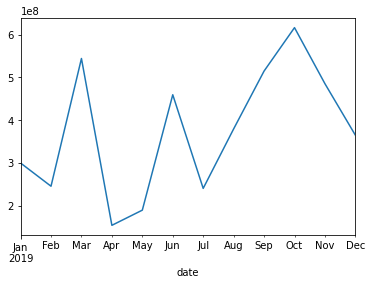

In [114]:
monthly_rain = df.mean_rain.resample('M').sum()
monthly_rain.plot()

In [120]:
np_arr =np.load('/Volumes/lacie_msc_datascience/msc_thesis/github_pycharm/sum_rain2019.npy', allow_pickle=True)
df = pd.DataFrame({'date': np_arr[:, 0], 'total rain': np_arr[:, 1].astype(int)})
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.head()

,total rain
date,
2019-01-01 00:00:00,4
2019-01-01 00:05:00,0
2019-01-01 00:10:00,0
2019-01-01 00:15:00,6
2019-01-01 00:20:00,18


<AxesSubplot:ylabel='Frequency'>

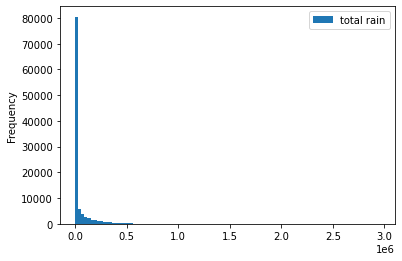

In [121]:
df.plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

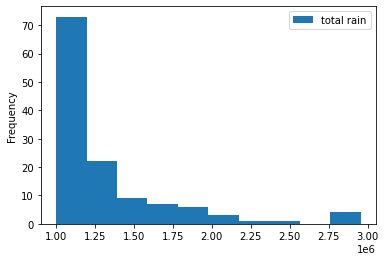

In [122]:
df[df['total rain']>1000000].plot.hist()

In [123]:
df[df['total rain'] == df['total rain'].max()]

,total rain
date,
2019-06-06,2955275


In [124]:
2955275 * 0.01 * 0.01

295.52750000000003

In [125]:
df2 = df[df.index.month == 6]
df2 = df2[df2.index.day == 6]
df2.head(10)

,total rain
date,
2019-06-06 00:00:00,2955275
2019-06-06 00:05:00,1523977
2019-06-06 00:10:00,1649908
2019-06-06 00:15:00,1663556
2019-06-06 00:20:00,1797998
2019-06-06 00:25:00,1976869
2019-06-06 00:30:00,1991128
2019-06-06 00:35:00,1900455
2019-06-06 00:40:00,1771922


In [126]:
def plot_radar(rdr):
    plt.imshow(np.squeeze(rdr))
    plt.axis('off')
    plt.show()

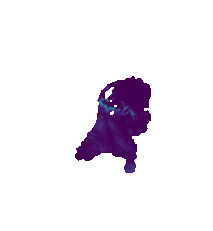

In [128]:
fn = '201906060000.nc'
rdr = load_radar(filename=fn, dir_rtcor=dir_rtcor, rtcor_fbase=rtcor_fbase, dir_aart=dir_aart, aart_fbase=aart_fbase)
plot_radar(rdr)

In [129]:
n = 288*100
files_sample = np.random.choice(files, n)

print('Sampled size is {:.2f}% of the actual dataset'.format(100*len(files_sample)/len(files)))

Sampled size is 26.99% of the actual dataset


In [131]:
sample_sum=0
n_pixels=0
for file in tqdm(files_sample):
    rdr = load_radar(filename=file, dir_rtcor=dir_rtcor, rtcor_fbase=rtcor_fbase, dir_aart=dir_aart, aart_fbase=aart_fbase,as_int=True)
    sample_sum+= int(rdr.filled(0).sum())

    # Nr of unmasked pixels:
    n_pixels+= 55739
sample_avg = sample_sum/n_pixels
print(sample_avg)

  4%|▍         | 1122/28800 [00:42<17:35, 26.23it/s] 


KeyboardInterrupt: 

In [ ]:
sum_x_min_mean_square=0
n_pixels=0
for file in tqdm(files_sample):
    rdr = load_radar(filename=file, dir_rtcor=dir_rtcor, rtcor_fbase=rtcor_fbase, dir_aart=dir_aart, aart_fbase=aart_fbase,as_int=True)

    try:
        int(rdr.sum())
        sum_x_min_mean_square +=  np.sum(np.square(rdr - sample_avg))
    except:
        sum_x_min_mean_square +=  np.sum(np.square(np.repeat(0,55739) - sample_avg))
    n_pixels+= 55739
sample_std =  sum_x_min_mean_square/n_pixels
print(sample_std)

In [134]:
ts = '201906060000'
path = dir_aart + aart_fbase + ts + '.nc'

ds = netCDF4.Dataset(path, 'r')
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.5
    history: Metadata adjusted by ADAGUC from KNMIHDF5 to NetCDF-CF
    dimensions(sizes): y(765), x(700), time(1)
    variables(dimensions): float64 y(y), float64 x(x), float64 time(time), |S1 geographic(), |S1 image1_calibration(), uint16 image1_image_data(time, y, x), |S1 overview(), |S1 radar1(), |S1 radar2(), |S1 radar3(), |S1 product(), |S1 iso_dataset(), |S1 projection()
    groups: 

In [135]:
x = ds['x'][:][0]
y = ds['y'][:][0]
print(x,y)
p = Proj("+proj=stere +lat_0=90 +lon_0=0.0 +lat_ts=60.0 +a=6378.137 +b=6356.752 +x_0=0 +y_0=0")
lon, lat = p(x, y, inverse=True)
print(lat, lon)

0.5 -3650.5
55.969160591296045 0.007847661848348265


In [140]:
def plot_on_map(ts, dir_aart, aart_fbase, dir_rtcor, rtcor_fbase, ftype='.nc', res='l'):
    '''
    Plot radar file on top of map.
    ts: Input is timestamp in format yyyymmddhhmm (e.g. 202001010000)
    ftype: file type of the radar file, this can be .nc or .h5
    res: resolution, can be c (crude), l (low), i (intermediate), h (high), f (full)
    '''

    proj = Proj("+proj=stere +lat_0=90 +lon_0=0.0 +lat_ts=60.0 +a=6378.137 +b=6356.752 +x_0=0 +y_0=0")

    # All images are plotted on the same map
    # Get the map from random nc file
    path = dir_aart + aart_fbase + '201901010000.nc'
    with netCDF4.Dataset(path, 'r') as ds:
        # Get coordinates of the pixels
        xx, yy = np.meshgrid(ds['x'][:], ds['y'][:])
        lon, lat = proj(xx, yy, inverse=True)
        # Plot values on map
        iso_dict = ds['iso_dataset'].__dict__
        min_x = float(iso_dict['min_x'].replace('f', ''))
        min_y = float(iso_dict['min_y'].replace('f', ''))
        max_x = float(iso_dict['max_x'].replace('f', ''))
        max_y = float(iso_dict['max_y'].replace('f', ''))

    rain = np.squeeze(load_radar(filename=ts+ftype, dir_rtcor=dir_rtcor, rtcor_fbase=rtcor_fbase, dir_aart=dir_aart, aart_fbase=aart_fbase,as_int=True))
    rain[rain == 65535 ] = 0

    # Plot the precipitation on map
    mp = mpl_toolkits.Basemap(projection='stere',
                         lat_0=90,
                         lon_0=0,
                         lat_ts=60,
                         llcrnrlon=min_x,   # lower longitude
                         llcrnrlat=min_y,    # lower latitude
                         urcrnrlon=max_x,   # uppper longitude
                         urcrnrlat=max_y,   # uppper latitude
                         resolution='l'
                        )
    mp.drawcoastlines()
    mp.drawstates()
    mp.drawcountries()

    xx, yy = mp(lon, lat)
    #cm = LinearSegmentedColormap.from_list('whitebluered', [[1,1,1],[0,0,1],[1,0,0]])
    cmap = cm.Blues

    cmap.set_under('white')
    plt.contourf(xx, yy, rain, cmap=cmap, vmin=30, vmax=1000)
    print(np.unique(rain)[:10])
    plt.colorbar(extend='both')
    plt.show()


In [141]:
ts = '201906060000'
plot_on_map(ts, dir_aart, aart_fbase, dir_rtcor, rtcor_fbase, ftype='.h5')

AttributeError: module 'mpl_toolkits' has no attribute 'Basemap'

### .npy aart files

In [142]:
aart_dir_np = '/Volumes/lacie_msc_datascience/msc_thesis/ceph_knmimo/preprocessed/aart/'
files = sorted([f for f in listdir(radar_dir_np) if isfile(join(radar_dir_np, f)) and f.startswith('2019')])
print(len(files))

6120


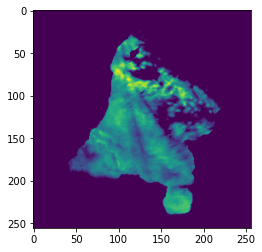

In [143]:
fn = '201906060000'
path = aart_dir_np + '/{}.npy'.format(fn)

rain = np.load(path)
# set masked values to 0
mask = (rain == 6553500)
rain[rain == 6553500] = 0
# Expand dimensions from (w,h) to (w,h,c=1)
rain = np.expand_dims(rain, axis=-1)


mx = np.ma.masked_array(rain, mask)
plt.imshow(np.squeeze(mx))

In [149]:
def crop_center(img,cropx=350,cropy=384):
    y,x = img.shape#[:2]
    startx = 20+x//2-(cropx//2)
    starty = 40+y//2-(cropy//2)
    return img[starty:starty+cropy,startx:startx+cropx]

w = 350
h = 384
rain2 = crop_center(np.squeeze(rain), w, h)
mask2 = crop_center(mask, w, h)

mx2 = np.ma.masked_array(rain2, mask2)
plt.imshow(np.squeeze(mx2))
mx2.shape

ValueError: too many values to unpack (expected 2)

In [150]:
def uncrop_center(img,cropx=350,cropy=384):
    y,x = img.shape
    startx = 20+x//2-(cropx//2)
    starty = 40+y//2-(cropy//2)
    return img[starty:starty+cropy,startx:startx+cropx]

w = 350
h = 384
rain2 = crop_center(np.squeeze(rain), w, h)
mask2 = crop_center(mask, w, h)

mx2 = np.ma.masked_array(rain2, mask2)
plt.imshow(np.squeeze(mx2))
mx2.shape

ValueError: too many values to unpack (expected 2)

### Rain labels

In [153]:
label_dir_rtcor = '/Volumes/lacie_msc_datascience/msc_thesis/ceph_knmimo/rtcor_rain_labels/2019/'

In [160]:
import shutil
import os

# Define the source and destination path
source = '/Volumes/lacie_msc_datascience/msc_thesis/ceph_knmimo/rtcor_rain_labels/2019/07/'
destination = '/Volumes/lacie_msc_datascience/msc_thesis/ceph_knmimo/rtcor_rain_labels/2019/'

# code to move the files from sub-folder to main folder.
files = os.listdir(source)
for file in files:
    file_name = os.path.join(source, file)
    shutil.move(file_name, destination)
print("Files Moved")

Files Moved


In [19]:
label_dir_rtcor = '/Volumes/lacie_msc_datascience/msc_thesis/ceph_knmimo/rtcor_rain_labels/2019/'

labels = sorted([f for f in listdir(label_dir_rtcor) if isfile(join(label_dir_rtcor, f)) and f.endswith('.npy')])
len(labels)

52113

In [20]:
rainy_days = []
for label in labels[:10000]:
    norain = np.load(label_dir_rtcor + label)
    if not norain:
        rainy_days.append(label)
len(rainy_days)

3748